# Variational Autoencoder

## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

## 导入概率分布模块

In [2]:
import tensorflow_probability as tfp
ds = tfp.distributions

## 超参

In [3]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28, 28, 1)
N_Z = 2
EPOCH = 100

## 导入数据

In [4]:
(train_images, _), (test_images, _) = keras.datasets.fashion_mnist.load_data()

## 数据处理

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

## 数据丢入tfdataset

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## 生成特征标签

In [7]:
encoder = [
    keras.layers.InputLayer(input_shape=DIMS),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(units=N_Z*2),
]

## 还原图片

In [8]:
decoder = [
    keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    keras.layers.Reshape(target_shape=(7, 7, 64)),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"),
]

## 定义模型

In [9]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1])
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))
        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

## 损失

In [10]:
optimizer =keras.optimizers.Adam(1e-3)

## 优化

In [11]:
losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

## 加载模型 

In [12]:
model = VAE(enc = encoder, dec = decoder, optimizer = optimizer)

## 绘制曲线

In [13]:
example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=8, zm=2):
    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(zip([example_data, example_data_reconstructed, samples], ["data", "data recon", "samples"])):
        for ex in range(nex):
            axs[axi, ex].matshow(dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1)
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

## 训练

Epoch: 99 | recon_loss: 3.2413101196289062 | latent_loss: 4.598211288452148


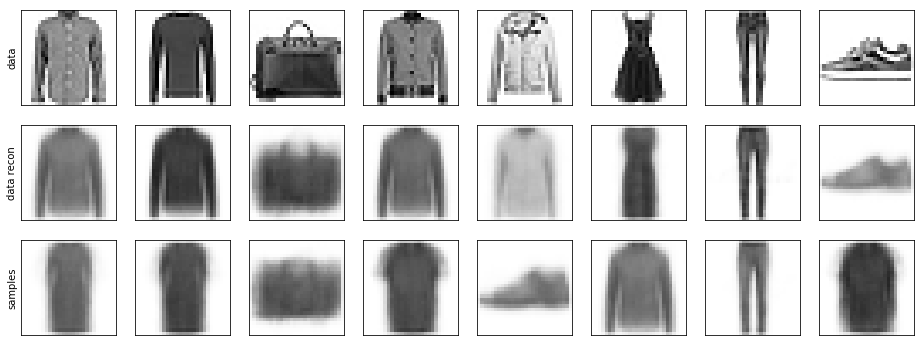

In [14]:
for epoch in range(EPOCH):
    for batch, train_x in enumerate(train_dataset):
        model.train(train_x)
    loss = []
    for batch, test_x in enumerate(test_dataset):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()
    print("Epoch: {} | recon_loss: {} | latent_loss: {}".format(epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]))
    plot_reconstruction(model, example_data)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.5, 279.5, 279.5, -0.5)

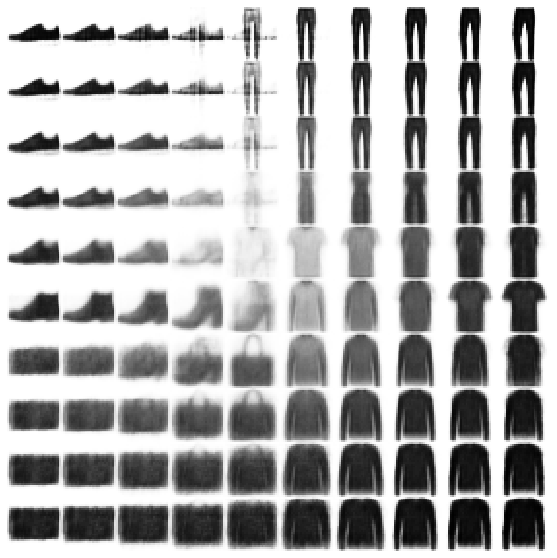

In [15]:
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

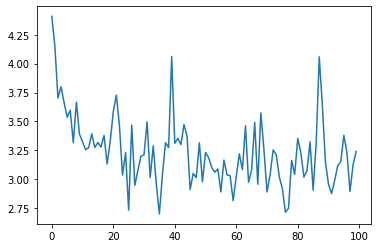

In [16]:
plt.plot(losses.recon_loss.values)

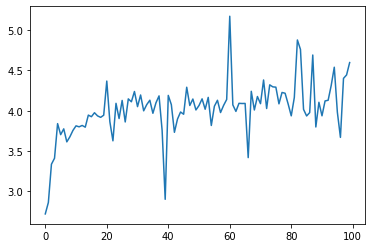

In [17]:
plt.plot(losses.latent_loss.values)

In [18]:
model.save_weights('./save/save_weights/model_weights.h5')